# Описание задачи

**ПРЕДСКАЗАНИЕ СТОИМОСТИ СТРАХОВКИ**


В данной задаче требуется предсказать стоимость страховки для клиента. В датасете располагаются основные сведения о нем, такие как: возраст, пол, индекс массы тела, .... 

Датасет взят с платформы kaggle: https://www.kaggle.com/datasets/mirichoi0218/insurance

Задача регрессионная

Для решения задачи будет проведет подробный разведочный анализ данных, предобработка, выбор наилучшей модели, подбор параметров и прогноз.

# Начало работы

## Подключение библиотек

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score

from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
sns.set_style('whitegrid')

## Функции и переменные

In [114]:
RANDOM_STATE = 100
SPLIT_TEST_SIZE = 0.2 # размер тестовой выборки
NUM_SPLIT_FOR_GRID = 5 #на сколько частей будет разбиваться выборка при подборе параметров
TRESHOLD_FOR_CORR = 0.1 #порог значения корреляции, ниже которого будем отбрасывать признаки
TRESHOLD_FOR_HIGH_CORR = 0.6 #при этом пороге корреляции будем тщательнее исследовать на предмет выбросов
TRESHOLD_FOR_HIGH_CORR_BETWEEN_FEATURE = 0.8 #если корреляция выше - удаляемм один из коррелируемых признаков

COLOR_PLOT = 'deepskyblue' #цвет графиков


def del_from_list(list_el, new_el):
    """
    Функция удаления элементов из массива
    """
    if np.isin(new_el, list_el).sum():
        return np.setdiff1d(list_el, new_el)
    else:
        return list_el

## Загрузка данных

In [115]:
data = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Основная информация о данных

In [116]:
print(data.shape)

(1338, 7)


In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


у нас идеальные данные с точки зрения предобработки: пропущенных значений нет, все типы соответствуют своим значениям. Но нужно будет изучить их распределения, все имеющиеся значения (для категориальных), выбросы. Но прежде изучим целевую переменную - charges

# Анализ целевой переменной

In [118]:
data.charges.describe()

count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64

Видим очень большое смещение вправо (большая роазница между максимумом и 3ьим квантилем), распределение не похоже на нормальное, плюс возможны сильные выбросы справа. поверим это на графиках

<AxesSubplot:xlabel='charges'>

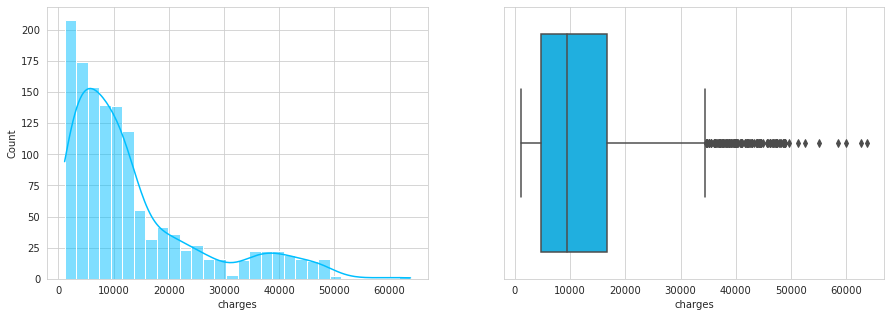

In [119]:
fig, axis = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(data=data, x='charges', ax=axis[0], color=COLOR_PLOT, kde=True)
sns.boxplot(data=data, x='charges', ax=axis[1], color=COLOR_PLOT)

графики еще раз убедили нас в том, что распределение далеко от нормального, но оно похоже на логонормальное, прологарифмируем целевую переменную и посмотрим на новые графики:

In [120]:
data['chargesLog'] = np.log(data.charges)

<AxesSubplot:xlabel='chargesLog'>

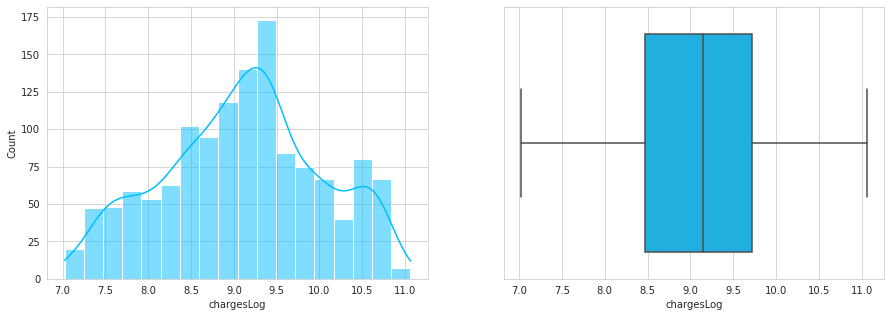

In [121]:
fig, axis = plt.subplots(ncols=2, figsize=(15,5))
sns.histplot(data=data, x='chargesLog', ax=axis[0], color=COLOR_PLOT, kde=True)
sns.boxplot(data=data, x='chargesLog', ax=axis[1], color=COLOR_PLOT)

Распределение стало более похоже на нормальное + ушли выбросы. япроедем тест Шапиро на нормальность:

In [122]:
print(stats.shapiro(data.chargesLog))

ShapiroResult(statistic=0.9831657409667969, pvalue=2.2936005525386882e-11)


Распределение все еще не нормальное, хотя теперь видна центральная тенденция, возможно вносит вклад ярко выраженная вторая мода, но там довольно много наблюдений, мы не можем их отсечь как выбросы, поэтому будем пробовать работать с такой переменной 

# Типы данных

In [123]:
data.dtypes.value_counts()

object     3
float64    3
int64      2
dtype: int64

## Категориальные признаки

In [124]:
data_non_numeric = data.select_dtypes(exclude=[np.number])
data_non_numeric.head()

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast
2,male,no,southeast
3,male,no,northwest
4,male,no,northwest


In [125]:
col_non_numeric = data_non_numeric.columns.values
col_non_numeric

array(['sex', 'smoker', 'region'], dtype=object)

Мы отобрали все не числовые признаки, нужно проверить их уникальные значения - нет ли ошибок в значениях

In [126]:
for col in col_non_numeric:
    print(col, ':', data[col].unique())

sex : ['female' 'male']
smoker : ['yes' 'no']
region : ['southwest' 'southeast' 'northwest' 'northeast']


Имеем чистые данные среди категориальных признаков, ошибочных значений среди них нет

## Числовые признаки

In [127]:
data_numeric = data.select_dtypes(include=[np.number])
data_numeric.head()

,age,bmi,children,charges,chargesLog
0,19,27.900,0,16884.92400,9.734176
1,18,33.770,1,1725.55230,7.453302
2,28,33.000,3,4449.46200,8.400538
3,33,22.705,0,21984.47061,9.998092
4,32,28.880,0,3866.85520,8.260197


In [128]:
col_numeric = [col for col in data_numeric.columns.values if col not in ['charges', 'chargesLog']]
col_numeric

['age', 'bmi', 'children']

Посмотрим на описательные статистики

In [129]:
data.describe()

,age,bmi,children,charges,chargesLog
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265,9.098659
std,14.049960,6.098187,1.205493,12110.011237,0.919527
min,18.000000,15.960000,0.000000,1121.873900,7.022756
25%,27.000000,26.296250,0.000000,4740.287150,8.463853
50%,39.000000,30.400000,1.000000,9382.033000,9.146552
75%,51.000000,34.693750,2.000000,16639.912515,9.719558
max,64.000000,53.130000,5.000000,63770.428010,11.063045


Анализ показал, что со значениями числовых  принаков так же все нормально, ошибочные значения отсутствуют 

# Анализ категориальных признаков

## Распределение

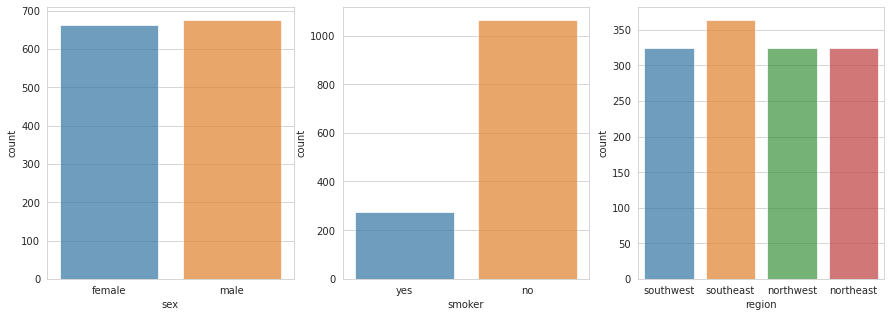

In [130]:
num_rows = ceil(len(col_non_numeric)/3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15,5))

for y, col in enumerate(col_non_numeric):    
    if num_rows > 1:
        i, j = divmod(y, 3)
        ax=axes[i,j]
    else:
        ax = axes[y]
    sns.countplot(data=data, x=col, alpha=0.7, ax=ax) 
    

По графикам можно сделать вывод, что значения признаков пола и региона примерно распределены равномерно в нашем датасете, а вот число некурящих предобладает над курящими, но, тем не менее, мы не имеем признаков, к примеру, сосредоточенных только возле одного значения, что, несомненно, хорошо.

## Влияние на целевую переменную

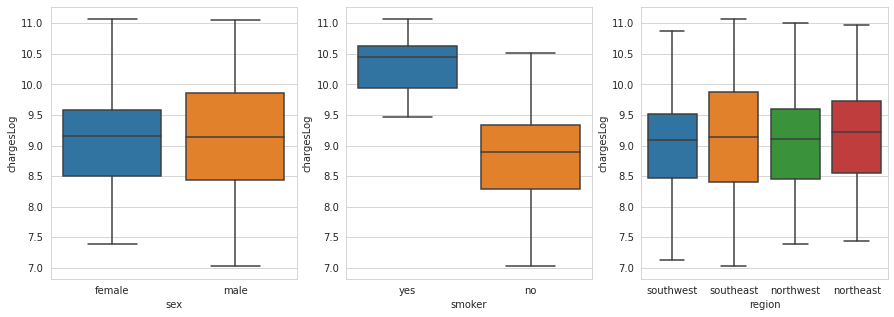

In [131]:
fig, axes = plt.subplots(num_rows, 3, figsize=(15,5))
for y, col in enumerate(col_non_numeric):
    if num_rows > 1:
        i, j = divmod(y, 3)
        ax=axes[i,j]
    else:
        ax = axes[y]
    sns.boxplot(data=data, x=col, y='chargesLog', ax=ax)

По графикам отчетливо видно, что признаки sex и region не несут существенного вклада в значение целевой переменной, значение которой примерно на одном уровне для разных значений этих признаков, поэтому их можно исключить из дальнейшего анализа. Так же можно заметить, что у курильщиков медианная стоимость страховки смещена вверх, т.е. стоимость страховки для них распределена логарифмически 

In [132]:
ColForDel = ['sex', 'region']
data.drop(columns=ColForDel, axis=1, inplace=True)
#и удалить из массива с категориальными столбцами
col_non_numeric = del_from_list(col_non_numeric, ColForDel)

In [133]:
col_non_numeric

array(['smoker'], dtype=object)

Единственный категориальный признак в нашей модели - курение

# Анализ числовых признаков

## Распределение

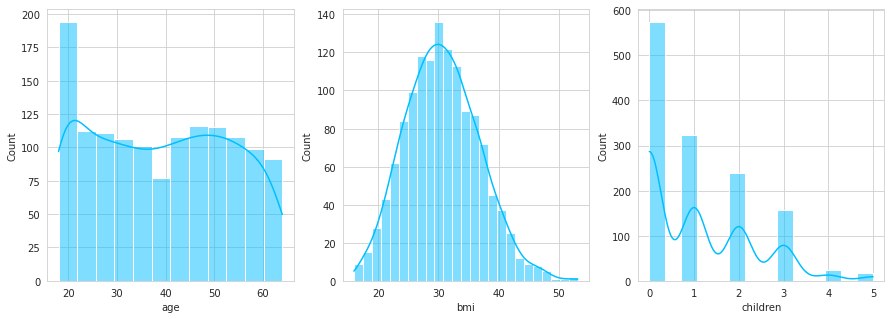

In [134]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
for i, col in enumerate(col_numeric):
    sns.histplot(data=data, x=col, color=COLOR_PLOT, ax=axes[i], kde=True)
    

Признак bmi имеет распределение, похожее на нормальное, children - экспоненциальное, а признак age близок к равномерному, если исключить большое количесвто людей около 20 лет

## Влияние на целевую переменную

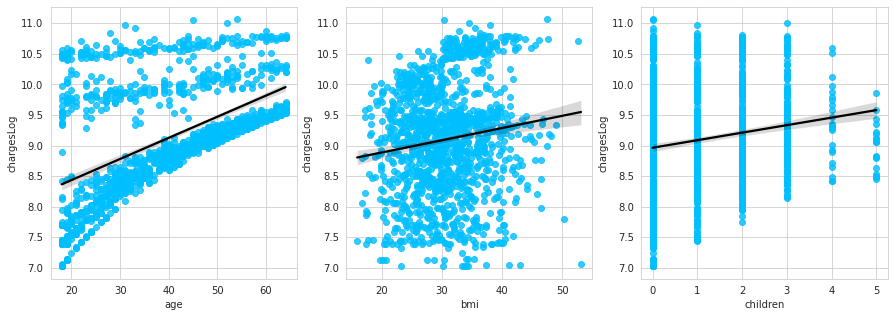

In [135]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
for i, col in enumerate(col_numeric):
    sns.regplot(data=data, x=col, y='chargesLog', scatter_kws={ "color": COLOR_PLOT}, \
                line_kws={"color": "black"}, ax=axes[i])

По графикам складывается впечатление, что корреляция довольно слабая, проведем корреляционный анализ

## Кореляционный анализ

<AxesSubplot:>

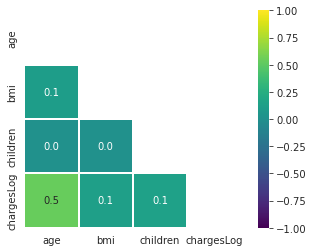

In [136]:
data_num_corr = data[col_numeric].join(data.chargesLog)
corr_matrix = data_num_corr.corr(method='spearman')

corr_matrix[abs(corr_matrix) <= TRESHOLD_FOR_CORR] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = "viridis"

sns.heatmap(corr_matrix,  mask=mask, linewidths=0.1, vmax=1.0, vmin=-1.0,  square=True, cmap=cmap, 
            annot=True, fmt=".1f")


Как мы и предполагали по графикам, корреляция слабая, сильнее всего - с признаком age. Но, т.к. признаков не много, мы оставим их все. Плюс ко всему, видим, что корреляция между признаками имеется только между возрастом и индексом массы тела, но, тк она маленькая, исклчать признаки из за нее не станем.

# Feature engineering

## Добавление нового признака IdealBmi

Располагая информацией, что идеальный индекс массы тела колеблется в интервале от 18.5 до 24.9, введем новую переменную категориальную, которая будет говорить идеальный индекс или нет - IdealBmi

In [137]:
data['IdealBmi'] = np.where((data.bmi < 24.9) & (data.bmi > 18.5), 1, 0)

Посмотрим на окончательный вид датасета: 

In [138]:
#data=data.drop(['IdeakBmi'], axis=1)
data.head()


,age,bmi,children,smoker,charges,chargesLog,IdealBmi
0,19,27.900,0,yes,16884.92400,9.734176,0
1,18,33.770,1,no,1725.55230,7.453302,0
2,28,33.000,3,no,4449.46200,8.400538,0
3,33,22.705,0,no,21984.47061,9.998092,1
4,32,28.880,0,no,3866.85520,8.260197,0


## Преобразование категориальных признаков

Преобразуем категориальный признак sex в численный, где 0 - это не курит (no), 1 - иначе

In [141]:
data['smoker'].replace({'no':0, 'yes':1}, inplace=True)

In [142]:
data.head()

,age,bmi,children,smoker,charges,chargesLog,IdealBmi
0,19,27.900,0,1,16884.92400,9.734176,0
1,18,33.770,1,0,1725.55230,7.453302,0
2,28,33.000,3,0,4449.46200,8.400538,0
3,33,22.705,0,0,21984.47061,9.998092,1
4,32,28.880,0,0,3866.85520,8.260197,0


# Подготовка данных к моделированию

## Разделение выборки на признаки и целевую переменную

In [164]:
X = data.drop(columns=['charges', 'chargesLog'], axis=1)
y = data.chargesLog

In [165]:
print('количество пропущенных значений в выборке:', X.isna().sum().sum())


количество пропущенных значений в выборке: 0


## Нормализация числовых признаков

In [166]:
#отбираем числовые признаки
X_numeric = X.select_dtypes(include=[np.number])
numeric_cols = X_numeric.columns.values
print(numeric_cols)

['age' 'bmi' 'children' 'smoker' 'IdealBmi']


In [167]:
X.head()

,age,bmi,children,smoker,IdealBmi
0,19,27.900,0,1,0
1,18,33.770,1,0,0
2,28,33.000,3,0,0
3,33,22.705,0,0,1
4,32,28.880,0,0,0


In [169]:
ns = MinMaxScaler()
X[numeric_cols] = ns.fit_transform(X[numeric_cols])
X.head()

,age,bmi,children,smoker,IdealBmi
0,0.021739,0.321227,0.0,1.0,0.0
1,0.000000,0.479150,0.2,0.0,0.0
2,0.217391,0.458434,0.6,0.0,0.0
3,0.326087,0.181464,0.0,0.0,1.0
4,0.304348,0.347592,0.0,0.0,0.0


# Моделирование

## Сравнение простых моделей с параметрами по умолчанию для выбора наилучшей модели

Будем рассматривать несколько моделей:
+ Ридж регрессия
* Лассо регрессия
* ElasticNet
* SVR
- Случайный лес

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=SPLIT_TEST_SIZE,
                                                    random_state=RANDOM_STATE)

In [176]:
models = [Ridge(), Lasso(alpha=0.001), ElasticNet(alpha=0.001), SVR(), RandomForestRegressor()]
scores = dict()
for m in models:
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    
    
    print(f'model: {str(m)}')
    print(f'RMSE: {round(np.sqrt(mean_squared_error(y_test, y_pred)), 3)}')
    print(f'R²: {round(r2_score(y_test, y_pred), 3)}')
    print('-'*30, '\n')

model: Ridge()
RMSE: 0.434
R²: 0.768
------------------------------ 

model: Lasso(alpha=0.001)
RMSE: 0.435
R²: 0.767
------------------------------ 

model: ElasticNet(alpha=0.001)
RMSE: 0.434
R²: 0.768
------------------------------ 

model: SVR()
RMSE: 0.357
R²: 0.843
------------------------------ 

model: RandomForestRegressor()
RMSE: 0.407
R²: 0.796
------------------------------ 



Лучше всего себя покал метод опорных векторов, поэтому далее сосредоточимся на нем.

##  Подбор параметров и предсказание с ипользованием SVR

parameters_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma':[0.01, 0.1, 1, 10, 100]
}

In [185]:
model = SVR()

svr_cv = GridSearchCV(model,
                       parameters_grid,
                       cv=NUM_SPLIT_FOR_GRID,
                       n_jobs=-1)

svr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 1, 10, 100]})

In [182]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [186]:
print(f"Лучшие параметры: {svr_cv.best_params_}")
print(f"Лучший R² (train): {svr_cv.best_score_}")

Лучшие параметры: {'C': 10, 'gamma': 1}
Лучший R² (train): 0.8214076004286891


Попробуем рассмотреть другие значения параметров, располагая их текущими лучшими значениями

In [188]:
parameters_grid = {
    'C': [ 6, 10, 15, 50],
    'gamma':[0.6, 1, 5]
}

In [189]:
model = SVR()

svr_cv = GridSearchCV(model,
                       parameters_grid,
                       cv=NUM_SPLIT_FOR_GRID,
                       n_jobs=-1)

svr_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [6, 10, 15, 50], 'gamma': [0.6, 1, 5]})

In [190]:
print(f"Лучшие параметры: {svr_cv.best_params_}")
print(f"Лучший R² (train): {svr_cv.best_score_}")

Лучшие параметры: {'C': 50, 'gamma': 0.6}
Лучший R² (train): 0.8216036365101373


Разница не критичная с предыдущими значениями, поэтому остановимся на значениях C = 50 и gamma = 0.6

## Прогноз

In [193]:
svr_mod = SVR(gamma=svr_cv.best_params_["gamma"], C=svr_cv.best_params_["C"])

# Fit the model on train set
svr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = svr_mod.predict(X_test)

print(f"- {svr_mod.__class__.__name__}")
print(f'RMSE: {round(np.sqrt(mean_squared_error(y_test.values, y_pred)), 3)}')
print(f'R²: {round(r2_score(y_test.values, y_pred), 3)}')

- SVR
RMSE: 0.358
R²: 0.842


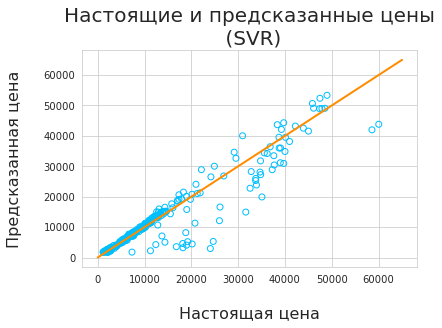

In [200]:
actual_price = np.exp(y_test.values)
predicted_price = np.exp(y_pred)

plt.figure()
plt.title("Настоящие и предсказанные цены\n (SVR)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color=COLOR_PLOT, marker="o", facecolors="none")
plt.plot([0, 65000], [0, 65000], "darkorange", lw=2)
#plt.xlim(0, 500000)
#plt.ylim(0, 500000)
plt.xlabel("\nНастоящая цена", fontsize=16)
plt.ylabel("Предсказанная цена\n", fontsize=16)
plt.show()